In [1]:
#Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

2024-03-22 00:48:45.301188: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-22 00:48:45.383513: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-22 00:48:45.406061: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-22 00:48:45.849891: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
# Settting the path to dataset
data_dir = 'Rice Seed Dataset'

In [3]:
# Get the list of all image files in the directory
all_image_files = [os.path.join(data_dir, class_folder, filename) for class_folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, class_folder)) for filename in os.listdir(os.path.join(data_dir, class_folder)) if filename.endswith(".jpg")]

# Create labels based on folder names or any other logic suitable for your dataset
all_image_labels = [os.path.basename(os.path.dirname(filepath)) for filepath in all_image_files]

# Map string labels to integer labels
label_mapping = {label: str(idx) for idx, label in enumerate(set(all_image_labels))}
all_image_labels = [label_mapping[label] for label in all_image_labels]

# Create a DataFrame to store file paths and labels
df = pd.DataFrame({'filepath': all_image_files, 'label': all_image_labels})

# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [4]:
# Create data generators for training and testing
img_size = (255, 255)
batch_size = 16

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, x_col='filepath', y_col='label', target_size=img_size, batch_size=batch_size, class_mode='binary')
test_generator = test_datagen.flow_from_dataframe(dataframe=test_df, x_col='filepath', y_col='label', target_size=img_size, batch_size=batch_size, class_mode='binary', shuffle=False)


Found 805 validated image filenames belonging to 2 classes.
Found 202 validated image filenames belonging to 2 classes.


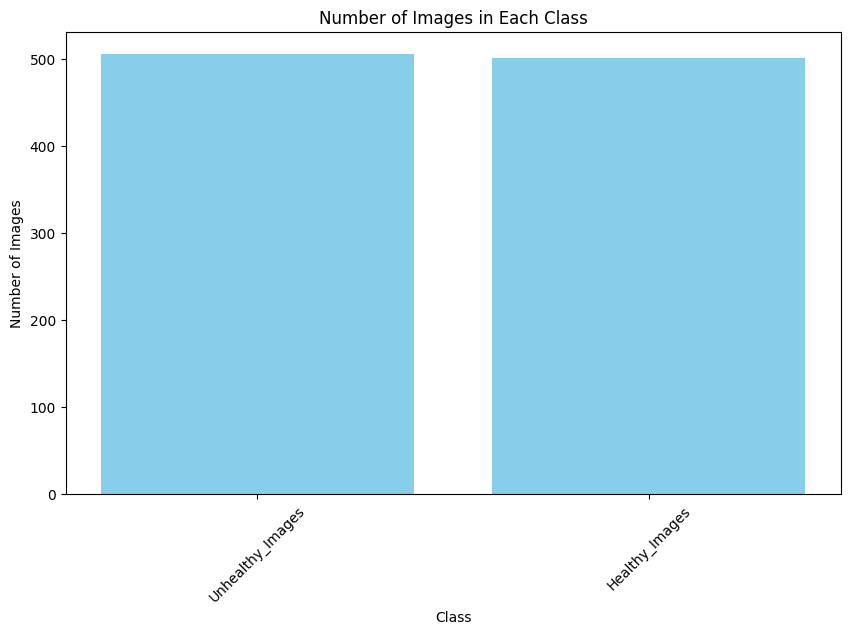

In [5]:
import matplotlib.pyplot as plt
train_dir = 'Rice Seed Dataset'

# Count the number of images in each class folder
class_counts = {}
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        class_counts[class_folder] = num_images

# Plot the number of images in each class
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.xticks(rotation=45)
plt.show()

In [6]:
# Build the CNN(VGG) model
model = models.Sequential()
model.add(layers.Conv2D(256, (3, 3), activation='relu', input_shape=(255, 255, 3)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid')) 


2024-03-22 00:48:47.161986: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-22 00:48:47.167679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-22 00:48:47.167847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-22 00:48:47.168505: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [7]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1),  # Model checkpoint
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='min', verbose=1)  # Early stopping
]

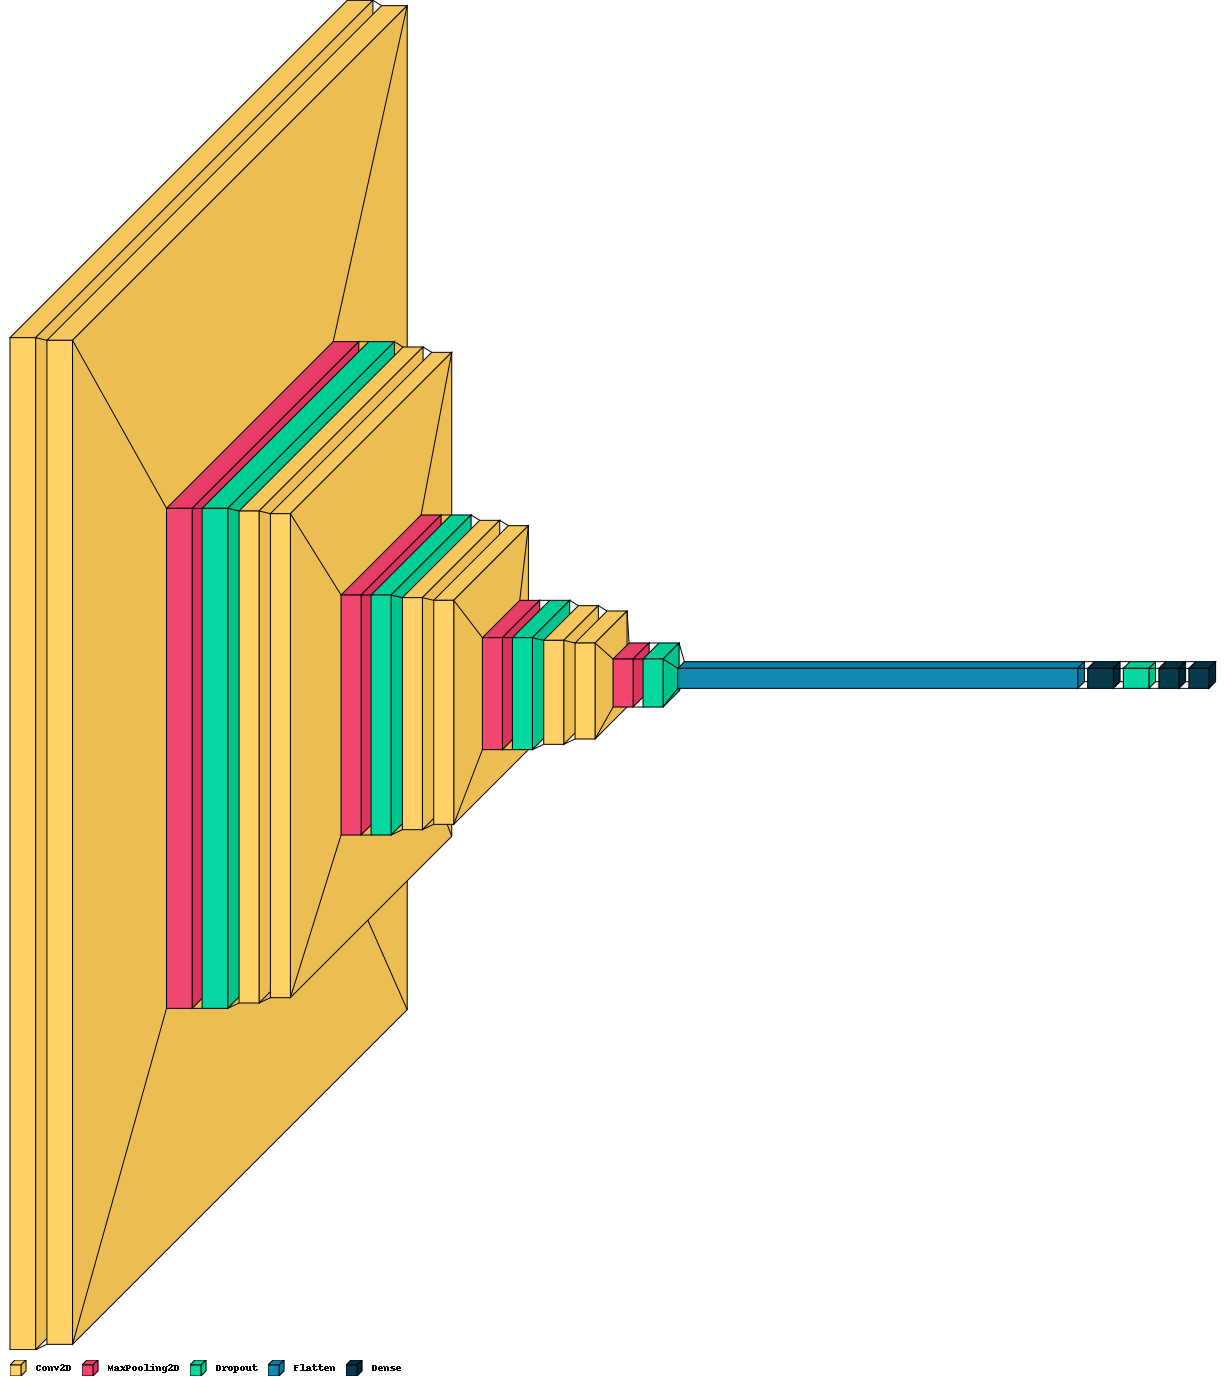

In [8]:
# Visualize the model
import visualkeras
from PIL import ImageFont  
visualkeras.layered_view(model, legend=True)  

In [9]:
# Train the model
history = model.fit(
    train_generator,
    workers=12,
    validation_data = test_generator, 
    epochs = 50,
    callbacks=callbacks)

Epoch 1/50


2024-03-22 00:48:50.107232: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-03-22 00:48:54.341237: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


51/51 [==============================] - ETA: 0s - loss: 0.6949 - accuracy: 0.4944
Epoch 1: val_accuracy improved from -inf to 0.50495, saving model to model.h5
51/51 [==============================] - 268s 2s/step - loss: 0.6949 - accuracy: 0.4944 - val_loss: 0.6930 - val_accuracy: 0.5050
Epoch 2/50
51/51 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.4907
Epoch 2: val_accuracy did not improve from 0.50495
51/51 [==============================] - 36s 689ms/step - loss: 0.6939 - accuracy: 0.4907 - val_loss: 0.6932 - val_accuracy: 0.4950
Epoch 3/50
51/51 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5130
Epoch 3: val_accuracy did not improve from 0.50495
51/51 [==============================] - 37s 692ms/step - loss: 0.6931 - accuracy: 0.5130 - val_loss: 0.6931 - val_accuracy: 0.4950
Epoch 4/50
51/51 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.4882
Epoch 4: val_accuracy did not improve from 0.50495
51/51 [===

In [10]:
# Load the best model
loaded_model = models.load_model('model.h5')

In [11]:
# Evaluate the model
test_loss, test_acc = loaded_model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc}')

13/13 [==============================] - 4s 266ms/step - loss: 0.2596 - accuracy: 0.9109
Test Accuracy: 0.9108911156654358


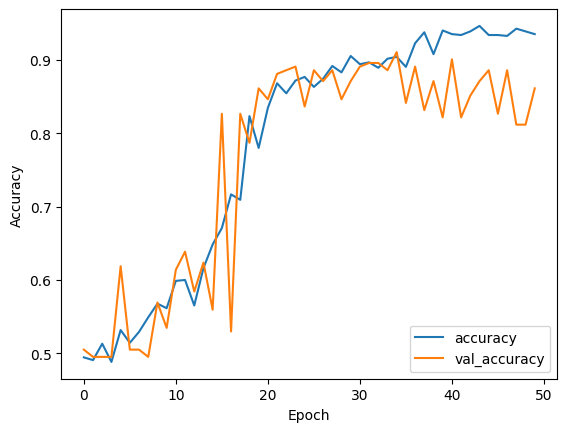

In [12]:
# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

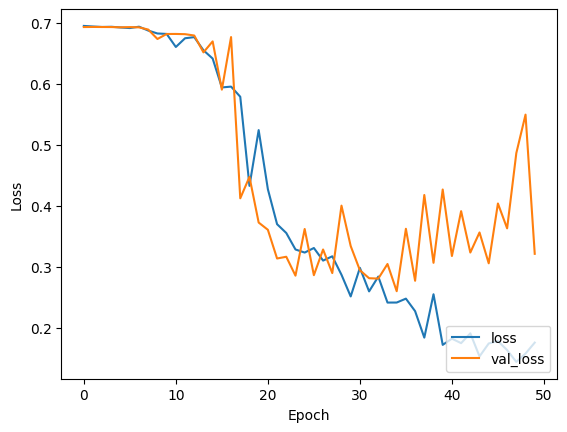

In [13]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

/tmp/ipykernel_20348/3994734455.py:30: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = loaded_model.predict_generator(test_generator)


Accuracy: 0.91
Precision: 0.91
Recall: 0.91
F1 Score: 0.91


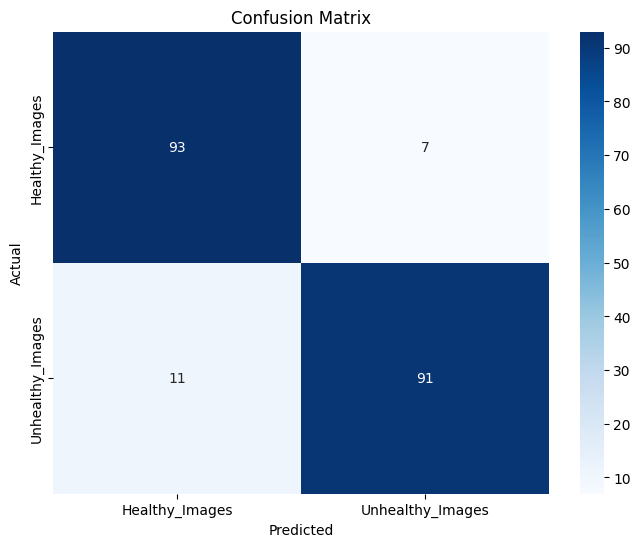

In [15]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    # Calculate additional metrics
    accuracy = np.trace(cm) / np.sum(cm)
    precision = np.diagonal(cm) / np.sum(cm, axis=0)
    recall = np.diagonal(cm) / np.sum(cm, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {np.mean(precision):.2f}")
    print(f"Recall: {np.mean(recall):.2f}")
    print(f"F1 Score: {np.mean(f1_score):.2f}")

    plt.show()
    
# Predict using the loaded model
test_generator.reset()
predictions = loaded_model.predict_generator(test_generator)
predictions = np.where(predictions > 0.5, 1, 0)
true_labels = test_generator.classes

# Get class names
class_names = label_mapping

# Plot confusion matrix
plot_confusion_matrix(true_labels, predictions, class_names)

In [16]:
# Get class names
class_dict = label_mapping
# Convert dictionary values to strings
class_name = np.array(list(class_dict.keys()))


In [17]:
print(class_name)

['Healthy_Images' 'Unhealthy_Images']
